# **IRWA_LAB_PART2**

# **0. LOADINGS**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('stopwords')

from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import json
import string
import re
import pandas as pd
from collections import Counter
import math


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
docs_path = '/content/drive/MyDrive/RIAW/IRWA_data_2024/data/farmers-protest-tweets.json'
with open(docs_path) as fp:
    lines = fp.readlines()
lines = [l.strip().replace(' +', ' ') for l in lines]

tweets = [json.loads(line.strip()) for line in lines]

In [ ]:
print("Total number of tweets : {}".format(len(tweets)))

Total number of tweets : 117407


In [ ]:

evaluation_file_path = '/content/drive/MyDrive/RIAW/IRWA_data_2024/data/evaluation.csv'

df_evaluation = pd.read_csv(evaluation_file_path, sep=";")
df_evaluation.head()

,docId,query_id,label
0,doc_156,1.0,0.0
1,doc_1039,1.0,0.0
2,doc_1047,1.0,1.0
3,doc_1685,1.0,0.0
4,doc_2100,1.0,1.0


## **Bidirectional Mapping for the tweet’s Ids with the document ids for evaluation**

In [ ]:
docs_path_map = '/content/drive/MyDrive/RIAW/IRWA_data_2024/data/tweet_document_ids_map.csv'

df = pd.read_csv(docs_path_map)


doc_to_tweet_map = dict(zip(df['docId'], df['id']))  #map doc to tweet id

tweet_to_doc_map = dict(zip(df['id'], df['docId']))  #map tweet_id to doc


doc_id = 'doc_0'
tweet_id = doc_to_tweet_map.get(doc_id)
print(f"doc_id {doc_id} have id {tweet_id}")


doc_id_10 = tweet_to_doc_map.get(1364505314586951680)
print(f"doc_id {doc_id_10} have id {1364505314586951680}")

doc_id doc_0 have id 1364506249291784198
doc_id doc_10 have id 1364505314586951680


# **1. INDEXING**

## **Build Inverted Index**

In [ ]:
def build_terms(line):

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    line = re.sub(r"http\S+|www\S+|https\S+", '', line, flags=re.MULTILINE)  #remove URLs

    line = line.lower() #lowercase

    tokens = line.split() #tokenize


    processed_tokens = []
    for token in tokens:

        if token.startswith('#'):
            processed_tokens.append(token) #keep hasthags exactly as they are
        else:
            token = token.translate(str.maketrans('', '', string.punctuation)) #remove punctuations

            if token and token not in stop_words: #eliminate the stopwords
                stemmed_token = stemmer.stem(token) #stemming
                processed_tokens.append(stemmed_token)

    return processed_tokens

In [ ]:
def create_inverted_index_return_big_number(tweets):

    index = defaultdict(list)  #dict for inverted index

    for tweet in tweets:
        tweet_id = tweet['id']
        terms = build_terms(tweet['content'])  #preprocess content of the tweet with our function from part 1

        for term in terms:
            if tweet_id not in index[term]:  #no repetition of ids
                index[term].append(tweet_id)  #add to the list of postings for this term

    return index

In [ ]:
def create_inverted_index(tweets, tweet_to_doc_map):

    index = defaultdict(list)  #dict for inverted index

    for tweet in tweets:
        tweet_id = tweet['id']
        doc_id = tweet_to_doc_map.get(tweet_id)  #get document id

        if doc_id is not None:  #if it's none then it's in hindi i guess
            terms = build_terms(tweet['content'])  #preprocess content of the tweet with our function from part 1

            for term in terms:
                if doc_id not in index[term]:  #no repetition of ids
                    index[term].append(doc_id)  #add to the list of postings for this term

    return index

In [ ]:
inverted_index = create_inverted_index(tweets, tweet_to_doc_map)

In [ ]:
#example

i=0
for term, doc_ids in inverted_index.items():
    print(f"'{term}': {doc_ids}")
    print()
    i+=1
    if i>5:
      break

'world': ['doc_0', 'doc_38', 'doc_52', 'doc_86', 'doc_111', 'doc_143', 'doc_187', 'doc_248', 'doc_252', 'doc_336', 'doc_460', 'doc_508', 'doc_519', 'doc_689', 'doc_751', 'doc_913', 'doc_926', 'doc_997', 'doc_1057', 'doc_1059', 'doc_1066', 'doc_1262', 'doc_1346', 'doc_1377', 'doc_1451', 'doc_1479', 'doc_1502', 'doc_1538', 'doc_1563', 'doc_1570', 'doc_1599', 'doc_1685', 'doc_1724', 'doc_1727', 'doc_1735', 'doc_1835', 'doc_1843', 'doc_1900', 'doc_1920', 'doc_2110', 'doc_2127', 'doc_2181', 'doc_2239', 'doc_2294', 'doc_2383', 'doc_2410', 'doc_2413', 'doc_2452', 'doc_2506', 'doc_2580', 'doc_2636', 'doc_2652', 'doc_2683', 'doc_2726', 'doc_2854', 'doc_2882', 'doc_2904', 'doc_2974', 'doc_3014', 'doc_3078', 'doc_3105', 'doc_3182', 'doc_3191', 'doc_3206', 'doc_3292', 'doc_3503', 'doc_3527', 'doc_3554', 'doc_3622', 'doc_3726', 'doc_3737', 'doc_3764', 'doc_3765', 'doc_3767', 'doc_3771', 'doc_3772', 'doc_3774', 'doc_3777', 'doc_3781', 'doc_3783', 'doc_3785', 'doc_3787', 'doc_3790', 'doc_3825', 'doc_

In [ ]:
#return doc ids if the doc has every term in the query

def search_conjunctive_query(query, index):

    query_terms = build_terms(query)

    if not query_terms:
        return []

    doc_lists = []
    for term in query_terms:
        if term in index:
            doc_lists.append(set(index[term]))  #working with sets to do intersections
        else:
            return [] #if the term is not in the index, then return nothin

    result_docs = set.intersection(*doc_lists) if doc_lists else [] #AND

    return list(result_docs)


## **Propose Test Queries**

In [ ]:
#cambiar a otras

test_queries = ["why are Indian protesting about farmers",
                "who supports farmers in india",
                "what are farmers rights in india",
                "how can indians support farmers now",
                "indian government farmers laws"]

In [ ]:
for query in test_queries:
    result = search_conjunctive_query(query, inverted_index)
    print(f"Documents that contain all the terms '{query}': {result}")

Documents that contain all the terms 'why are Indian protesting about farmers': ['doc_28072', 'doc_38874', 'doc_41854', 'doc_29514', 'doc_40977', 'doc_6059', 'doc_12535', 'doc_14321', 'doc_13046', 'doc_1666', 'doc_11845', 'doc_9676', 'doc_23540', 'doc_14979', 'doc_25505', 'doc_14687', 'doc_5078', 'doc_29355', 'doc_14245', 'doc_13937', 'doc_30952', 'doc_44995', 'doc_35730', 'doc_5074', 'doc_7584', 'doc_13963', 'doc_30394', 'doc_42848', 'doc_10497', 'doc_5442', 'doc_20255', 'doc_30706', 'doc_29446', 'doc_44495', 'doc_36688', 'doc_37257', 'doc_4241', 'doc_47236', 'doc_47551', 'doc_22605', 'doc_29521', 'doc_14132', 'doc_37117', 'doc_4305', 'doc_33879', 'doc_13995', 'doc_40716', 'doc_13703', 'doc_10920', 'doc_39063', 'doc_19612', 'doc_21486', 'doc_32354', 'doc_43279', 'doc_28619', 'doc_8164', 'doc_14487', 'doc_6916', 'doc_45490', 'doc_30746', 'doc_37836', 'doc_10817', 'doc_685', 'doc_14246', 'doc_29115', 'doc_45192', 'doc_43710', 'doc_37077', 'doc_27054', 'doc_27486', 'doc_36992', 'doc_3713

## **Ranking Results With TF-IDF**

In [ ]:
def create_inverted_index_tfidf(tweets, tweet_to_doc_map):
    """
    Implement the inverted index and compute tf, df, and idf.

    Returns:
    index - the inverted index containing terms as keys and the corresponding list of documents these keys appear in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appears in
    idf - inverse document frequency of each term
    """

    index = defaultdict(list)
    tf = defaultdict(list)
    df = defaultdict(int)
    idf = defaultdict(float)

    num_documents = len(set(tweet_to_doc_map.values()))

    for tweet in tweets:
        tweet_id = tweet['id']
        doc_id = tweet_to_doc_map.get(tweet_id)

        if doc_id is not None:
            terms = build_terms(tweet['content'])
            current_doc_index = defaultdict(list)

            # Create current document index
            for position, term in enumerate(terms):
                current_doc_index[term].append(position)

            # Normalize term frequencies
            norm = math.sqrt(sum(len(postings) ** 2 for postings in current_doc_index.values()))

            for term, postings in current_doc_index.items():
                tf_val = np.round(len(postings) / norm, 4)
                if doc_id not in index[term]:  # Avoid duplicates
                    index[term].append((doc_id, postings))
                    tf[term].append(tf_val)
                    df[term] += 1

    # Compute IDF
    for term in df:
        idf[term] = np.round(np.log(float(num_documents) / df[term]), 4)

    return index, tf, df, idf

In [ ]:
from collections import defaultdict, Counter
import numpy.linalg as la

def rank_documents(query, docs, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights.

    Returns:
    List of ranked documents along with their scores
    """

    # Process query into terms and initialize vectors
    query_terms = build_terms(query)
    query_vector = [0] * len(query_terms)
    doc_vectors = defaultdict(lambda: [0] * len(query_terms))

    # Count term frequency in query and normalize
    query_terms_count = Counter(query_terms)
    query_norm = la.norm([query_terms_count[term] for term in query_terms])

    # Build the query vector and each document vector
    for term_idx, term in enumerate(query_terms):
        if term in index:
            # Calculate the normalized term frequency for the query
            query_vector[term_idx] = (query_terms_count[term] / query_norm) * idf.get(term, 0)

            # Update document vectors with term frequencies and normalize
            for doc_idx, (doc, postings) in enumerate(index[term]):
                if doc in docs:
                    tf_norm = tf[term][doc_idx]  # Already normalized in tf calculation
                    doc_vectors[doc][term_idx] = tf_norm * idf[term]

    # Calculate normalized scores for each document
    doc_scores = []
    for doc, doc_vec in doc_vectors.items():
        doc_norm = la.norm(doc_vec)
        if doc_norm != 0:
            normalized_score = np.dot(doc_vec, query_vector) / doc_norm  # Normalize with document norm
            doc_scores.append([normalized_score, doc])

    # Sort documents by their relevance scores in descending order
    doc_scores.sort(reverse=True, key=lambda x: x[0])

    # Return ordered documents and their scores
    return [doc for _, doc in doc_scores], doc_scores




In [ ]:
inv_index_tfidf, tf, df, idf = create_inverted_index_tfidf(tweets, tweet_to_doc_map)


In [ ]:
#example
i=0
for term, doc_ids in inv_index_tfidf.items():
    print(f"'{term}': {doc_ids}")
    print()
    i+=1
    if i>5:
      break

'world': [('doc_0', [0]), ('doc_38', [12]), ('doc_52', [7]), ('doc_86', [6]), ('doc_111', [8]), ('doc_143', [0]), ('doc_187', [3]), ('doc_248', [15]), ('doc_252', [3]), ('doc_336', [9]), ('doc_460', [3]), ('doc_508', [7]), ('doc_519', [22]), ('doc_689', [5]), ('doc_751', [11]), ('doc_913', [0]), ('doc_926', [5]), ('doc_997', [14]), ('doc_1057', [7]), ('doc_1059', [4]), ('doc_1066', [7]), ('doc_1262', [12]), ('doc_1346', [9]), ('doc_1377', [2]), ('doc_1451', [7]), ('doc_1479', [1]), ('doc_1502', [1]), ('doc_1538', [0]), ('doc_1563', [1]), ('doc_1570', [3]), ('doc_1599', [14]), ('doc_1685', [3]), ('doc_1724', [3]), ('doc_1727', [11]), ('doc_1735', [4]), ('doc_1835', [6]), ('doc_1843', [15]), ('doc_1900', [10]), ('doc_1920', [15]), ('doc_2110', [0]), ('doc_2127', [9]), ('doc_2181', [0]), ('doc_2239', [4]), ('doc_2294', [9]), ('doc_2383', [7]), ('doc_2410', [1]), ('doc_2413', [6]), ('doc_2452', [9]), ('doc_2506', [14]), ('doc_2580', [6]), ('doc_2636', [6]), ('doc_2652', [21]), ('doc_2683',

In [ ]:
docs = list(set(doc for postings in inv_index_tfidf.values() for doc, _ in postings)) # Extract a unique list of document IDs (doc_id) from the inverted index

In [ ]:
for query in test_queries:
    results, scorees = rank_documents(query, docs, inv_index_tfidf, idf, tf)
    print(scorees, '\n')
    print(f"Ranking for query '{query}':\n")
    for result in results[:5]:
        print(f"Doc ID: {result}, Tweet ID: {doc_to_tweet_map.get(result)}")
    print("\n")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for query in test_queries[:1]:
    results, scores = rank_documents(query, docs, inv_index_tfidf, idf, tf)
    print(f"Ranking for query '{query}':\n")

    for result in results[:5]:
        tweet_id = doc_to_tweet_map.get(result)
        tweet_content = next((tweet['content'] for tweet in tweets if tweet['id'] == tweet_id), "Contenido no encontrado")

        print(f"Doc ID: {result}, Tweet ID: {tweet_id}, Tweet: {tweet_content}")
    print("\n")


Ranking for query 'why are Indian protesting about farmers':

Doc ID: doc_5202, Tweet ID: 1363976950579146756, Tweet: Inhumane behaviour by the Indian authorities continues against the farmers at the #FarmersProtest. All roads to the Protest site blocked with heavy presence of Police. #StandUp4HumanRights @UN @UNHumanRights 
https://t.co/LMoL4O8hMT
Doc ID: doc_8848, Tweet ID: 1363534700346826754, Tweet: New Indian Fake Drama. Weapons are coming to Farmer Protest from Pakistan.

India is master of FAKE stories.
#FarmersProtest
#Farmers
 https://t.co/2uB4qPP9rz
Doc ID: doc_9394, Tweet ID: 1363489149286834177, Tweet: Why are Indian farmers angry ???
This is the biggest protest ever against the government.
🤔🤔🤔🤔🤭🤭🤭🤭
Modi is now German Adolf Hitler.

#FarmersProtests #FarmersProtest
#India
#modi_rojgar_do #modi_rojgaar_do https://t.co/gHFFHiLIhm
Doc ID: doc_13090, Tweet ID: 1363042277095059456, Tweet: This is a great video about the Indian farmers! Recommended watch even if you have no affil

## **Selection of queries**

In [ ]:
def get_frequent_terms(df, top_n=20):

    return [term for term, count in df.most_common(top_n)]

def get_high_tfidf_terms(tf, idf, top_n=20):

    # The problem was that tf_val was likely a sequence of occurrences,
    # instead of the binary value (1) if a term was in the document or not.
    # We change the dictionary comprehension to iterate through the dictionary of documents instead,
    # and checking if the term exists in the current document's bag of words.
    tfidf_values = {}
    for term in tf:
        if term in idf:  # Make sure the term is in the IDF dictionary
            tfidf_values[term] = np.round(1 * idf[term], 4)

    sorted_terms = sorted(tfidf_values.items(), key=lambda x: x[1], reverse=True)
    return [term for term, value in sorted_terms[:top_n]]

# Get the most frequent terms
frequent_terms = get_frequent_terms(Counter(df))
print("Frequent Terms:", frequent_terms)

# Get terms with high TF-IDF values
high_tfidf_terms = get_high_tfidf_terms(tf, idf)
print("Terms with High TF-IDF Values:", high_tfidf_terms)



Frequent Terms: ['#farmersprotest', 'farmer', 'india', 'support', 'protest', 'amp', 'peopl', 'right', 'indian', 'govern', 'modi', '#releasedetainedfarmers', 'law', '#farmersmakeindia', '#indiabeingsilenced', 'stand', 'govt', 'thank', 'pleas', '#mahapanchayatrevolution']
Terms with High TF-IDF Values: ['breakingw', 'us🚜🌾w', '#petroldiesel', '#alcohol', '#cigarettes', '#tobacco', '#aatamnirbhartbharat', '#kissables', 'khanthefatima', 'mainabisme', 'proudindian', 'beinghuman', 'sarahwoodwrit', 'vivianavigil', 'bhasmasur', 'sallow', 'humankind', 'chopra', 'delhichalo', 'mkinthuk']


In [ ]:
#reformulate test_queries
test_queries = ["Who supports indian law",  #based on tf
                "Impact of government policies on farmers", #based on tf
                "Who is breaking in farmers' protest? ", #based on TF-IDF Values
                "what is the real issue? ",
                "who is against indian farmers"]  #query for contrast

# **2. EVALUATION**

## **Functions for Evaluation**

In [ ]:
from collections import defaultdict

# Define evaluation metric functions
def precision_at_k(retrieved_docs, relevant_docs, k):
    retrieved_relevant = sum(1 for doc in retrieved_docs[:k] if doc in relevant_docs)
    return retrieved_relevant / k

def recall_at_k(retrieved_docs, relevant_docs, k):
    retrieved_relevant = sum(1 for doc in retrieved_docs[:k] if doc in relevant_docs)
    return retrieved_relevant / len(relevant_docs) if relevant_docs else 0

def average_precision_at_k(retrieved_docs, relevant_docs, k):
    """Compute average precision at K."""
    hits = 0
    sum_precisions = 0.0
    for i, doc in enumerate(retrieved_docs[:k], start=1):
        if doc in relevant_docs:
            hits += 1
            sum_precisions += hits / i  # Precision at each relevant doc position
    return sum_precisions / hits if hits > 0 else 0.0

def f1_score_at_k(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

def dcg_at_k(retrieved_docs, relevant_docs, k):
    return sum((1 if doc in relevant_docs else 0) / np.log2(i + 2) for i, doc in enumerate(retrieved_docs[:k]))

def ndcg_at_k(retrieved_docs, relevant_docs, k):
    dcg_max = dcg_at_k(sorted(relevant_docs, reverse=True), relevant_docs, k)
    return dcg_at_k(retrieved_docs, relevant_docs, k) / dcg_max if dcg_max > 0 else 0

def reciprocal_rank(retrieved_docs, relevant_docs):
    """Compute reciprocal rank."""
    for i, doc in enumerate(retrieved_docs, start=1):
        if doc in relevant_docs:
            return 1 / i  # Return reciprocal of the rank of the first relevant doc
    return 0.0

# def mean_average_precision(results, relevant_docs, k):
#     """Compute mean average precision over multiple queries."""
#     avg_precisions = []
#     for query_id, retrieved_docs in results.items():
#         if query_id not in relevant_docs or not relevant_docs[query_id]:  # Check for missing relevant docs
#             print(f"Warning: No relevant docs found for Query ID {query_id}")
#             continue
#         ap = average_precision_at_k(retrieved_docs, relevant_docs[query_id], k)
#         avg_precisions.append(ap)
#         print(f"Query ID: {query_id}, Average Precision: {ap}")  # Debugging line
#     if avg_precisions:
#         return sum(avg_precisions) / len(avg_precisions)
#     else:
#         print("Warning: No queries had relevant documents for MAP calculation.")
#         return 0

# def mean_reciprocal_rank(results, relevant_docs):
#     """Compute mean reciprocal rank over multiple queries."""
#     reciprocal_ranks = []
#     for query_id, retrieved_docs in results.items():
#         if query_id not in relevant_docs or not relevant_docs[query_id]:  # Check for missing relevant docs
#             print(f"Warning: No relevant docs found for Query ID {query_id}")
#             continue
#         rr = reciprocal_rank(retrieved_docs, relevant_docs[query_id])
#         reciprocal_ranks.append(rr)
#         print(f"Query ID: {query_id}, Reciprocal Rank: {rr}")  # Debugging line
#     if reciprocal_ranks:
#         return sum(reciprocal_ranks) / len(reciprocal_ranks)
#     else:
#         print("Warning: No queries had relevant documents for MRR calculation.")
#         return 0

## **Case 1: Given 2 Queries With Ground-Truth Values**

In [ ]:
given_queries = {1: "people's rights?",
                 2: "Indian Government"}

In [ ]:
# Initialize ranked results dictionary
ranked_results = {}

# Iterate over given queries and rank documents for each query
for query_id, query_text in given_queries.items():
    results, doc_scores = rank_documents(query_text, docs, inv_index_tfidf, idf, tf)
    ranked_results[query_id] = list(zip(results, [score[0] for score in doc_scores]))

# Initialize relevant_docs dictionary
relevant_docs = {}
for query_id in given_queries.keys():
    # Create a set of relevant document IDs for each query based on ground truth
    relevant_set = set(df_evaluation[(df_evaluation['query_id'] == query_id) & (df_evaluation['label'] == 1)]['docId'])
    relevant_docs[query_id] = relevant_set

# Print ranked results
print("Ranked Results:")
for query_id, ranked_docs in ranked_results.items():
    print(f"Query ID {query_id} ranked docs: {ranked_docs[:15]}")  # Show top 5 results for each query

# Print relevant documents
print("\nRelevant Documents:")
for query_id, relevant_set in relevant_docs.items():
    print(f"Query ID {query_id} relevant docs: {relevant_set}")


Ranked Results:
Query ID 1 ranked docs: [('doc_634', 2.759679917128072), ('doc_2710', 2.759679917128072), ('doc_5751', 2.759679917128072), ('doc_7211', 2.759679917128072), ('doc_12963', 2.759679917128072), ('doc_14969', 2.759679917128072), ('doc_17371', 2.759679917128072), ('doc_17462', 2.759679917128072), ('doc_20726', 2.759679917128072), ('doc_21198', 2.759679917128072), ('doc_26919', 2.759679917128072), ('doc_27175', 2.759679917128072), ('doc_30019', 2.759679917128072), ('doc_31942', 2.759679917128072), ('doc_32033', 2.759679917128072)]
Query ID 2 ranked docs: [('doc_1273', 2.926968080625411), ('doc_1651', 2.926968080625411), ('doc_1666', 2.926968080625411), ('doc_3005', 2.926968080625411), ('doc_3116', 2.926968080625411), ('doc_5169', 2.926968080625411), ('doc_5180', 2.926968080625411), ('doc_6084', 2.926968080625411), ('doc_6749', 2.926968080625411), ('doc_7104', 2.926968080625411), ('doc_7255', 2.926968080625411), ('doc_7402', 2.926968080625411), ('doc_7570', 2.926968080625411), 

In [ ]:
K = 15  # Set K value for evaluation
average_precisions = []  # Initialize average_precisions
reciprocal_ranks = []

# Evaluate metrics for each query
print("\nEvaluation Results:")
for query_id in given_queries:
    retrieved_docs = [doc[0] for doc in ranked_results[query_id][:K]]
    relevant_set = relevant_docs[query_id]
    print(f"Query ID: {query_id}")
    print("Retrieved Docs:", retrieved_docs)
    print("Relevant Docs:", relevant_set)
    print("Common Docs:", set(retrieved_docs).intersection(relevant_set), "\n")

    # Compute metrics
    p_at_k = precision_at_k(retrieved_docs, relevant_set, K)
    r_at_k = recall_at_k(retrieved_docs, relevant_set, K)
    ap_at_k = average_precision_at_k(retrieved_docs, relevant_set, K)
    f1_at_k = f1_score_at_k(p_at_k, r_at_k)
    ndcg_at_k_val = ndcg_at_k(retrieved_docs, relevant_set, K)
    reciprocal_rank_val = reciprocal_rank(retrieved_docs, relevant_set)

    # Print metrics for the current query
    print(f"\nQuery ID: {query_id} - '{query_text}'")
    print(f"  Precision@{K}: {p_at_k}")
    print(f"  Recall@{K}: {r_at_k}")
    print(f"  F1-Score@{K}: {f1_at_k}")
    print(f"  Average Precision@{K}: {ap_at_k}")
    print(f"  NDCG@{K}: {ndcg_at_k_val}")
    print(f"  Reciprocal Rank: {reciprocal_rank_val}")

# Overall MAP and MRR

 # Append calculated values to the lists
    average_precisions.append(ap_at_k)  # Append ap_at_k to average_precisions
    reciprocal_ranks.append(reciprocal_rank_val)

map_score = sum(average_precisions) / len(average_precisions) if average_precisions else 0
mrr_score = sum(reciprocal_ranks) / len(reciprocal_ranks) if reciprocal_ranks else 0

print("\nOverall Evaluation Metrics:")
print(f"Mean Average Precision (MAP): {map_score}")
print(f"Mean Reciprocal Rank (MRR): {mrr_score}")



Evaluation Results:
Query ID: 1
Retrieved Docs: ['doc_634', 'doc_2710', 'doc_5751', 'doc_7211', 'doc_12963', 'doc_14969', 'doc_17371', 'doc_17462', 'doc_20726', 'doc_21198', 'doc_26919', 'doc_27175', 'doc_30019', 'doc_31942', 'doc_32033']
Relevant Docs: {'doc_5751', 'doc_9850', 'doc_10048', 'doc_4053', 'doc_3570', 'doc_3474', 'doc_5480', 'doc_2100', 'doc_3287', 'doc_5512', 'doc_9696', 'doc_6477', 'doc_8066', 'doc_1047', 'doc_9937'}
Common Docs: {'doc_5751'} 


Query ID: 1 - 'Indian Government'
  Precision@15: 0.06666666666666667
  Recall@15: 0.06666666666666667
  F1-Score@15: 0.06666666666666667
  Average Precision@15: 0.3333333333333333
  NDCG@15: 0.08530460913930236
  Reciprocal Rank: 0.3333333333333333
Query ID: 2
Retrieved Docs: ['doc_1273', 'doc_1651', 'doc_1666', 'doc_3005', 'doc_3116', 'doc_5169', 'doc_5180', 'doc_6084', 'doc_6749', 'doc_7104', 'doc_7255', 'doc_7402', 'doc_7570', 'doc_7634', 'doc_7778']
Relevant Docs: {'doc_1566', 'doc_1666', 'doc_2528', 'doc_3005', 'doc_3646',

## **Case 2: Our Own 5 Queries With Us Setting Ground-Truth**

In [ ]:
# Define the test queries with IDs for clarity
test_queries  = ["Who supports indian law",
                "Impact of government policies on farmers",
                "Who is breaking in farmers' protest? ",
                "what is the real issue? ",
                "who is against indian farmers"]

for query in test_queries[:5]:
    results, scores = rank_documents(query, docs, inv_index_tfidf, idf, tf)
    print(f"Ranking for query '{query}':\n")

    for result in results[:20]:
        tweet_id = doc_to_tweet_map.get(result)
        tweet_content = next((tweet['content'] for tweet in tweets if tweet['id'] == tweet_id), "Contenido no encontrado")

        print(f"Doc ID: {result}, Tweet ID: {tweet_id}, Tweet: {tweet_content}")
    print("\n")

Ranking for query 'Who supports indian law':

Doc ID: doc_9681, Tweet ID: 1363444730474885128, Tweet: @MEAIndia @DrSJaishankar Will you also be shooting off an angry letter to the 87 America farmers union supporting Indian's farmers in their struggle against the corporate-benefiting black laws?

https://t.co/atc5QCaUNH

#FarmersProtest #MSPLawForAllCrops
Doc ID: doc_10497, Tweet ID: 1363348220445925378, Tweet: 87 farmer organisations and food justice groups in the United States delivered a solidarity statement in support of Indian farmers' protests against the new farm laws.

#FarmersProtest https://t.co/PYklCc7xUI
Doc ID: doc_3390, Tweet ID: 1364130568808595456, Tweet: We can be proud of Ajit Singh Ji and the #FarmersProtest in 1907 whilst also supporting a peaceful and pragmatic end to the current protest. 

Remember, the Indian Supreme Court has already intervened:
- Laws on hold
- Offer to mediate 

#Pagdi_Sambhal_Jatta https://t.co/SpDD7gM4lZ
Doc ID: doc_3563, Tweet ID: 1364110026

In [ ]:

import pandas as pd

# Initialize an empty list to store ground truth data
ground_truth_data = []

# Example list of documents (add real documents as needed)
documents = [
    {"docId": "doc_10497", "text": "87 farmer organisations and food justice groups in the United States delivered a solidarity statement in support of Indian farmers' protests against the new farm laws."},
    {"docId": "doc_8259", "text": "Thank you @ABC, US farmer unions. Thank you for supporting the farmers protesting the draconian laws forced upon Indian farmers#FarmersProtests #farmersprotest #MSPLawForAllCrops #NoFarmersNoFood https://t.co/oOweacZlGl"},
    {"docId": "doc_27080", "text": "Disha Ravi, co-founder of @FFFIndia, was arrested and charged with sedition for editing a Toolkit on how to support the #FarmersProtest.  A 2016 report by @hrw found that the Indian government has been using the broadly-defined sedition law to squash dissent. https://t.co/rTlAn2hOrM"},
    {"docId": "doc_7834", "text": "@ZeeNews 60% of Indian Population either directly or indirectly support #FarmersProtest to repeal Kisan Laws to make a Reform Laws for incorporating MSP in 23 crops limiting stocking."},
    {"docId": "doc_29728", "text": "#FarmersProtests Milk &amp; food: Indian villages support protesting farmers Small villages around #Delhi are supporting the tens of thousands of farmers encamped around the capital as they demand the repeal of new agriculture laws"},

    {"docId": "doc_39522", "text": "One Size For All” for Policy resulted in disastrous #FarmLaws which has created huge impact on Indian Farmers , which resulted in #FarmersProtest ! They neither capable of understanding the problem not able to solve it. So we don’t need you here. #GoBackModiModi #GoBackModi https://t.co/2X0JpLeYSX"},
    {"docId": "doc_7237", "text": "@CNN @GLOBALNEWS @nytimes @CBCNews @BBCNews 250 Indian farmers died in protests Deliberate attempt by Government to ignore farmers rights, &amp; devastating impact of these laws  on livelihoods of millions in India. #ModiIgnoringFarmersDeaths #RepealFarmLaws #FarmersProtest https://t.co/PGEw9p9W7R"},
    {"docId": "doc_40794", "text": "@AJEYA21 @amandeepskoutl1 @open__age A. No governance by the government - MSP and legal methods to recoup losses B. Full market control by corporate power houses - they will determine prices based on customer demand and their ability to store produce. C. No competition - impact price #FarmersProtest"},
    {"docId": "doc_21821", "text": "Original Reporting | BJP Routed In Punjab Municipal Elections As #FarmersProtest Impacts Electoral Fortunes, from @amaanbali “We never voted during municipal elections but this time I told my sons and daughters to vote for the sake of farmers."},
    {"docId": "doc_18822", "text": "Farmers are the backbone of society. Their work not only ensures we have food to eat, it also impacts everything from the environment to the economy. #FarmersProtesthttps://t.co/GsC0cyFudI"},

    {"docId": "doc_26429", "text": "We need to stay united for the farmers. We are fighting with a dictator who is very powerful and cunning. They are looking for our weakness to break the protest #FarmersProtest #FarmersMakeIndia"},
    {"docId": "doc_38718", "text": "Informal school started by farmers' group at Delhi protest site resumes after two-week break #FarmersProtest #delhiprotest #schoolsreopening #edexlive https://t.co/FxSOnuC6sD"},
    {"docId": "doc_15428", "text": "@hrw @HRWDailyBrief Farmers r being arrested and tortured for protesting ; Modi gov is targeting Sikhs to break up #FarmersProtest, trying to label them as terrorists- this propaganda is being spread worldwide through Indian embassies/ this targeted vilification needs to be condemned. ⬇️ 😥 https://t.co/d5NW9xRl9f"},
    {"docId": "doc_35818", "text": "Breaking - approx $1 Billion was spent to create Riot like situation in India through 2021."},
    {"docId": "doc_8814", "text": "I’m sick of celebrities divorces becoming breaking news but the farmers protest in India and abducting a British citizen gets next to nothing coverage #FreeJaggiNow #FarmersProtest"},

    {"docId": "doc_8934", "text": "Over 2 million tweets asking for jobs in India shows the depth of unemployment in India.  #NarendraModi your propaganda have limits, start focusing on the real issues of the people 😏😏#modi_rojgar_do @narendramodi #indianeconomy #andolanjeevi #FarmersProtest #FuelPriceHike"},
    {"docId": "doc_28377", "text": "I still don't get how all of the sudden #ToolKit became the real issue here? How about we pay similar attention to the #FarmersProtest? Why is it that world's largest #democracy has become more of a joke and nothing else? #IStandWithFarmers #repealfarmlaws #Farmers"},
    {"docId": "doc_13070", "text": "When the mainstream (corporate) media discredit, demonize and ignore our real issues then you can imagine the consequences of corporate monopoly in Food grain or agriculture sector. #FarmersProtest via @volunteer4farmr"},

    {"docId": "doc_4215", "text": "@BrahamjotM @GovtOfIndia_ When RSS(Rashtriya Sevak Sangh) terrorists attacked protesting farmers at the Singhu border in Delhi it was the lowest day in Indian history. Why RSS chief Mohan Bhagawat has been given expensive Z+ security. He does not hold any constitutional post. #FarmersProtest"},
    {"docId": "doc_4329", "text": "The Indian government has deduced a dangerous fact, and that is, farmers, most of whom are Sikh, are not inherently violent. "},
    {"docId": "doc_2619", "text": "@ClaudiaWebbe @HCI_London Tell the High Commission to read the Indian Court order and not to muzzle your voice. Keep up with your good work. More power to you.✊ Keep raising the farmers' issues. 🙏 #FarmersProtest https://t.co/GfH2HtBvGp"},

]

# Dictionary defining relevant documents for each query
relevant_docs_custom = {
    1: {"doc_10497", "doc_8259", "doc_27080", "doc_7834","doc_29728"},
    2: {"doc_39522", "doc_7237", "doc_40794", "doc_21821","doc_18822"},
    3: {"doc_26429", "doc_38718", "doc_15428", "doc_35818","doc_8814"},
    4: {"doc_8934", "doc_28377", "doc_13070"},
    5: {"doc_4215", "doc_4329", "doc_2619"}
}

# Loop through each query and document to generate the ground truth
for query_id, relevant_docs in relevant_docs_custom.items():
    for doc in documents:
        # Assign 1 if the document is relevant to the query, 0 otherwise
        relevance_label = 1 if doc["docId"] in relevant_docs else 0
        # Append each (docId, query_id, label) triplet to ground truth data
        ground_truth_data.append({
            "docId": doc["docId"],
            "query_id": query_id,
            "label": relevance_label
        })

# Create a DataFrame from the ground truth data
ground_truth_df = pd.DataFrame(ground_truth_data)

# Save the DataFrame to a CSV file for future reference
ground_truth_df.to_csv("ground_truth.csv", index=False, sep=";")

print("Ground truth data saved to 'ground_truth.csv'")



Ground truth data saved to 'ground_truth.csv'


In [ ]:
import pandas as pd

# Assuming ground_truth_data has already been populated
ground_truth_df = pd.DataFrame(ground_truth_data)

# Initialize ranked results dictionary
ranked_results = {}

# Use test_queries as a dictionary to store query texts with IDs
test_queries = {1: "Who supports indian law",
                2: "Impact of government policies on farmers",
                3: "Who is breaking in farmers' protest?",
                4: "what is the real issue?",
                5: "who is against indian farmers"}

# Iterate over test queries and rank documents for each query
for query_id, query_text in test_queries.items():
    results, doc_scores = rank_documents(query_text, docs, inv_index_tfidf, idf, tf)
    ranked_results[query_id] = list(zip(results, [score[0] for score in doc_scores]))

# Initialize relevant_docs dictionary
relevant_docs = {}
for query_id in test_queries.keys():
    # Create a set of relevant document IDs for each query based on ground truth
    relevant_set = set(ground_truth_df[(ground_truth_df['query_id'] == query_id) & (ground_truth_df['label'] == 1)]['docId'])
    relevant_docs[query_id] = relevant_set

# Print ranked results
print("Ranked Results:")
for query_id, ranked_docs in ranked_results.items():
    print(f"Query ID {query_id} ranked docs: {ranked_docs[:15]}")  # Show top 15 results for each query

# Print relevant documents
print("\nRelevant Documents:")
for query_id, relevant_set in relevant_docs.items():
    print(f"Query ID {query_id} relevant docs: {relevant_set}")


Ranked Results:
Query ID 1 ranked docs: [('doc_9681', 2.7320568625122), ('doc_10497', 2.7320568625122), ('doc_3390', 2.7320568625121995), ('doc_3563', 2.7320568625121995), ('doc_5074', 2.7320568625121995), ('doc_6038', 2.7320568625121995), ('doc_8259', 2.7320568625121995), ('doc_13857', 2.7320568625121995), ('doc_26704', 2.7320568625121995), ('doc_27080', 2.7320568625121995), ('doc_27890', 2.7320568625121995), ('doc_46574', 2.7320568625121995), ('doc_48371', 2.7320568625121995), ('doc_42274', 2.6086295163082984), ('doc_46130', 2.588815931854206)]
Query ID 2 ranked docs: [('doc_39522', 3.987899719463868), ('doc_45442', 3.4139264871991615), ('doc_43710', 3.41392648719916), ('doc_23037', 3.4139264871991597), ('doc_14263', 3.3568561397733907), ('doc_7237', 3.356797403594503), ('doc_21223', 3.3475555335199445), ('doc_40794', 3.176859543952907), ('doc_183', 3.0740797078150077), ('doc_8024', 3.0740797078150077), ('doc_13667', 3.0740797078150077), ('doc_21821', 3.0740797078150077), ('doc_31138

In [ ]:
K = 15  # Set K value for evaluation
average_precisions = []  # Initialize average_precisions
reciprocal_ranks = []

# Asumiendo que 'given_queries' es una lista de IDs de las consultas
# y 'relevant_docs' es un diccionario con documentos relevantes para cada consulta
print("\nEvaluation Results:")
for query_id in test_queries:
    retrieved_docs = [doc[0] for doc in ranked_results[query_id][:K]]  # Obtener los primeros K documentos recuperados
    relevant_set = relevant_docs[query_id]  # Conjunto de documentos relevantes para la consulta actual

    print(f"Query ID: {query_id}")
    print("Retrieved Docs:", retrieved_docs)
    print("Relevant Docs:", relevant_set)
    print("Common Docs:", set(retrieved_docs).intersection(relevant_set), "\n")

    # Compute metrics
    p_at_k = precision_at_k(retrieved_docs, relevant_set, K)
    r_at_k = recall_at_k(retrieved_docs, relevant_set, K)
    ap_at_k = average_precision_at_k(retrieved_docs, relevant_set, K)
    f1_at_k = f1_score_at_k(p_at_k, r_at_k)
    ndcg_at_k_val = ndcg_at_k(retrieved_docs, relevant_set, K)
    reciprocal_rank_val = reciprocal_rank(retrieved_docs, relevant_set)

    # Print metrics for the current query
    print(f"\nQuery ID: {query_id} - '{test_queries[query_id]}'")  # Utiliza el texto de consulta
    print(f"  Precision@{K}: {p_at_k}")
    print(f"  Recall@{K}: {r_at_k}")
    print(f"  F1-Score@{K}: {f1_at_k}")
    print(f"  Average Precision@{K}: {ap_at_k}")
    print(f"  NDCG@{K}: {ndcg_at_k_val}")
    print(f"  Reciprocal Rank: {reciprocal_rank_val}")

    # Append calculated values to the lists
    average_precisions.append(ap_at_k)  # Append ap_at_k to average_precisions
    reciprocal_ranks.append(reciprocal_rank_val)

# Overall MAP and MRR
map_score = sum(average_precisions) / len(average_precisions) if average_precisions else 0
mrr_score = sum(reciprocal_ranks) / len(reciprocal_ranks) if reciprocal_ranks else 0

print("\nOverall Evaluation Metrics:")
print(f"Mean Average Precision (MAP): {map_score}")
print(f"Mean Reciprocal Rank (MRR): {mrr_score}")



Evaluation Results:
Query ID: 1
Retrieved Docs: ['doc_9681', 'doc_10497', 'doc_3390', 'doc_3563', 'doc_5074', 'doc_6038', 'doc_8259', 'doc_13857', 'doc_26704', 'doc_27080', 'doc_27890', 'doc_46574', 'doc_48371', 'doc_42274', 'doc_46130']
Relevant Docs: {'doc_8259', 'doc_7834', 'doc_10497', 'doc_27080', 'doc_29728'}
Common Docs: {'doc_8259', 'doc_10497', 'doc_27080'} 


Query ID: 1 - 'Who supports indian law'
  Precision@15: 0.2
  Recall@15: 0.6
  F1-Score@15: 0.3
  Average Precision@15: 0.3619047619047619
  NDCG@15: 0.42507895232375664
  Reciprocal Rank: 0.5
Query ID: 2
Retrieved Docs: ['doc_39522', 'doc_45442', 'doc_43710', 'doc_23037', 'doc_14263', 'doc_7237', 'doc_21223', 'doc_40794', 'doc_183', 'doc_8024', 'doc_13667', 'doc_21821', 'doc_31138', 'doc_32147', 'doc_41864']
Relevant Docs: {'doc_7237', 'doc_39522', 'doc_21821', 'doc_18822', 'doc_40794'}
Common Docs: {'doc_39522', 'doc_21821', 'doc_40794', 'doc_7237'} 


Query ID: 2 - 'Impact of government policies on farmers'
  Precisi

## **Visualization Using Word2Vec And t-SNE**

In [ ]:
#!pip install gensim scikit-learn matplotlib

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk

# Download the punkt tokenizer
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
terms_of_each_tweet = []

for tweet in tweets:
    if tweet['id'] in doc_to_tweet_map.values():
        terms_of_each_tweet.append(build_terms(tweet['content']))

In [ ]:
# Train Word2Vec model
model = Word2Vec(sentences=terms_of_each_tweet, vector_size=100, window=5, min_count=1, workers=4)


In [ ]:
def vectorize_tweet(tokens):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

tweet_vectors = np.array([vectorize_tweet(tokens) for tokens in terms_of_each_tweet])


In [ ]:
tsne = TSNE(n_components=2, random_state=42)
tweet_vectors_2d = tsne.fit_transform(tweet_vectors)


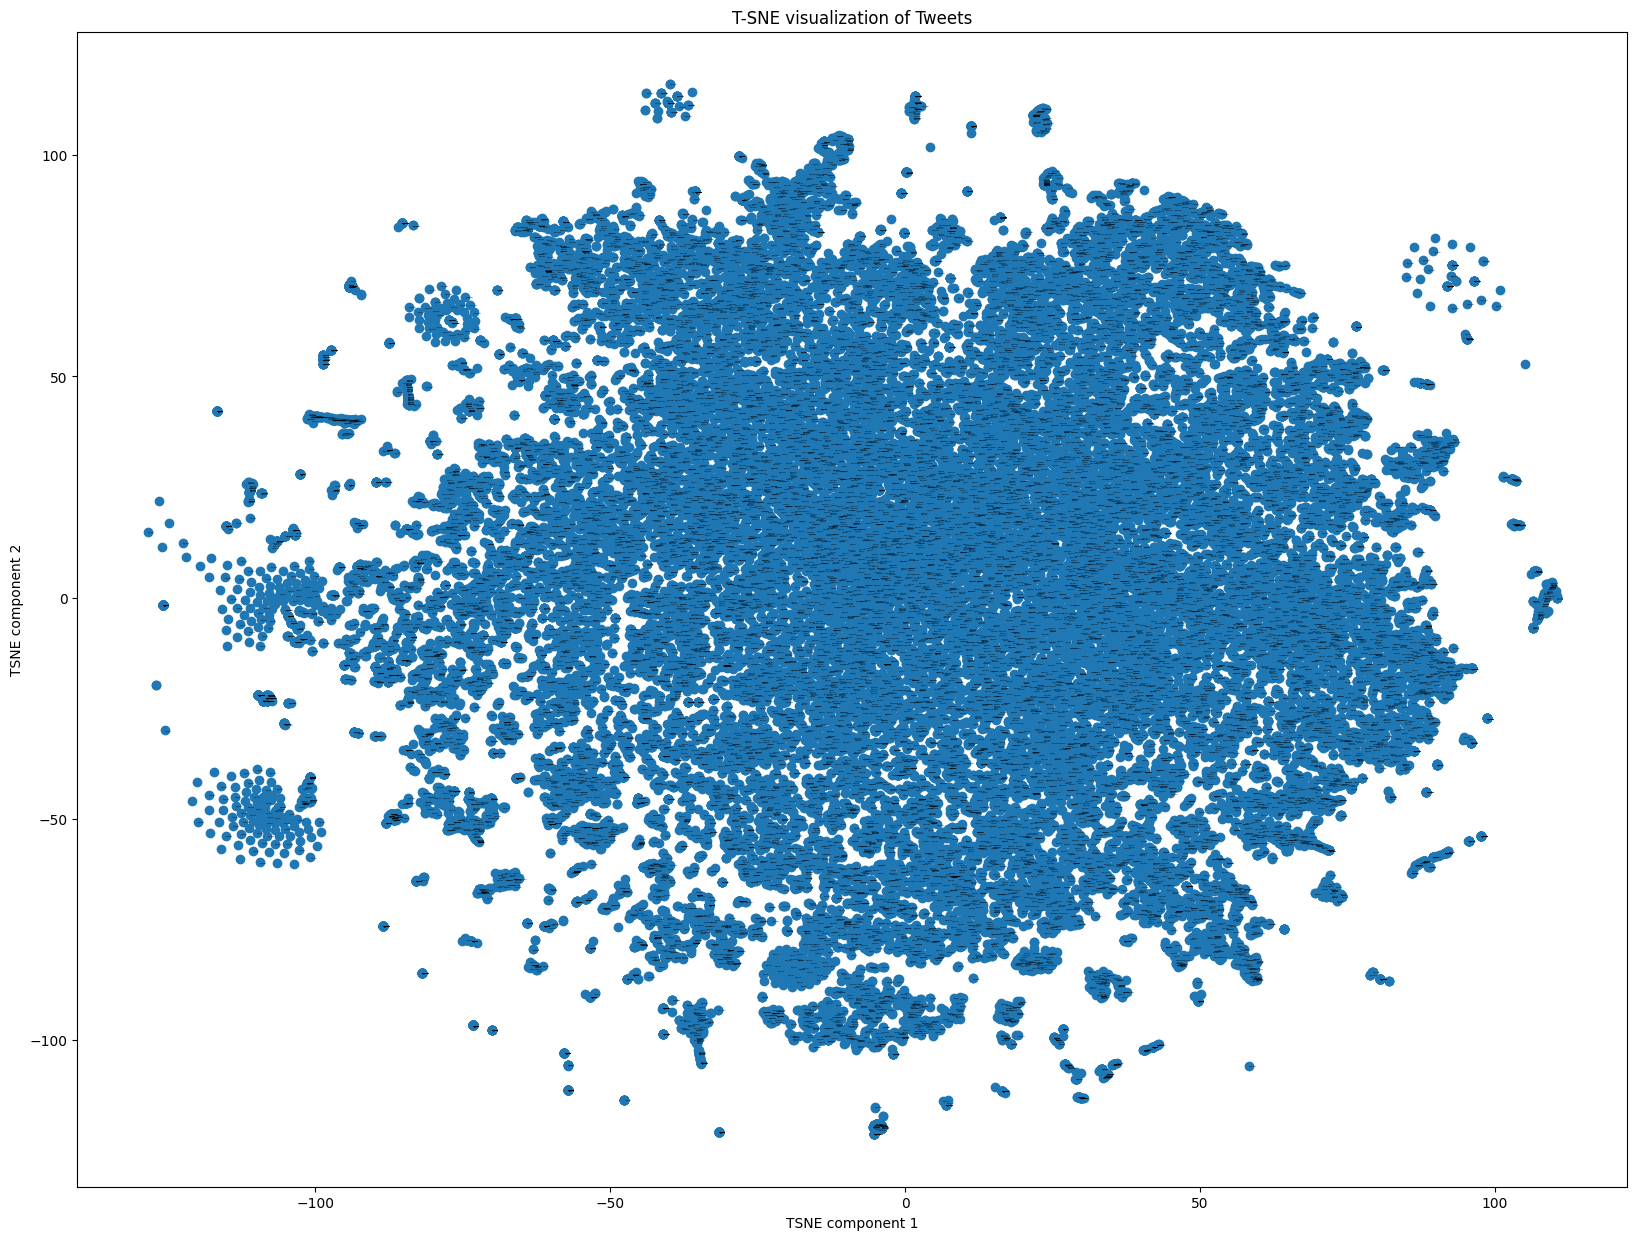

In [ ]:
plt.figure(figsize=(20, 15))
plt.scatter(tweet_vectors_2d[:, 0], tweet_vectors_2d[:, 1])

# Annotate only the tweets that were processed
for idx, terms in enumerate(terms_of_each_tweet):
    # Access the original tweet using the index directly
    original_tweet = tweets[idx]  # Adjust this based on your tweets list structure
    plt.annotate(tweet_to_doc_map.get(original_tweet['id']), (tweet_vectors_2d[idx, 0], tweet_vectors_2d[idx, 1]), fontsize=1)

plt.title('T-SNE visualization of Tweets')
plt.xlabel('TSNE component 1')
plt.ylabel('TSNE component 2')
plt.show()
